# Part 1: Fully Connected Layers

Daniel-Alexandru Bejan (474404)
Patrick Schaper (534366)

The provided dataset contains possible combinations for the game Yathzee. If you don’t know the rules for this dice game, please have a look at: https://en.wikipedia.org/wiki/Yahtzee.

Please note: the dataset is imbalanced. This means that you might need to balance it first
before you will get good results! There a several possible solutions, please read: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758 for a better understanding.

You will need to build a neural network that is able to predict the label for 5 thrown dice. The available labels are mentioned in the table below.

- 3-of-a-kind: Three dice the same.
- 4-of-a-kind: Four dice the same.
- Full-house: Three of one number and two of another
- small-straight Four sequential dice: (1-2-3-4, 2-3-4-5, or 3-4-5-6)
- Large-straight Five sequential dice: (1-2-3-4-5 or 2-3-4-5-6)
- Yathzee: All five dice the same
- Nothing: None of the above combinations has been thrown

**Goal of the assignment**

The overall goal is to experiment with deep learning and find out what gives you the
best results. Don’t forget to compare the results and write a conclusion!
Experiments we expect you to carry out:
- Playing around with different networks sizes
 - Different number of layers
 - Different number of neurons per layer
 - At least 6 different networks with a minimum of 1 hidden layer per network
- Comparison of different activation functions:
 - Sigmoid
 - Tanh
 - ReLu
- Difference with and without dropout.

The notebook should contain:
- For each neural network that you train: graphs from TensorBoard or Matplotlib showing the accuracy and the loss for train set and validation set and the accuracy scores for the test set.
- Your observations and conclusions per network (and graph)!
- An export of your best trained network and a way to run this exported model.

**Hints**

In order to build proper neural networks, keep in mind:
- Convert the labels into one-hot-encoded values.
- Use cross-entropy as loss function for classification.
- Create a proper output layer that uses SoftMax activation.
- Use the accuracy metric to measure your classification performance.
- Avoid overfitting by using dropout, a test set (which you use in the end) and cross validation.

Export your best model and add a cell to your notebook that loads the model and is
able to validate your model, by loading in a dataset from file and feeding it into the
network. This cell should show the accuracy of the classifier.


## Analyse the Data

In [1]:
import pandas as pd
import numpy as np

raw_df = pd.read_csv('MLBD-dataset-yahtzee.csv')
raw_df.head() 

,dice1,dice2,dice3,dice4,dice5,label
0,3,6,6,2,5,nothing
1,3,6,1,3,4,nothing
2,2,2,5,5,3,nothing
3,1,3,6,6,1,nothing
4,1,4,6,3,5,small-straight


In [2]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5832 entries, 0 to 5831
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dice1   5832 non-null   int64 
 1   dice2   5832 non-null   int64 
 2   dice3   5832 non-null   int64 
 3   dice4   5832 non-null   int64 
 4   dice5   5832 non-null   int64 
 5   label   5832 non-null   object
dtypes: int64(5), object(1)
memory usage: 273.5+ KB


In [3]:
raw_df.groupby(['label'])['label'].count()

label
four-of-a-kind      116
full-house          221
large-straight      178
nothing            3868
small-straight      549
three-of-a-kind     896
yathzee               4
Name: label, dtype: int64

### First result of analysing

We see a very unbalanced data set. One rubric stands out particularly strongly. The number of "yathzee's" is just 4. According to the rules of the game, a "yathzee" occurs when all dice show the same number. So we add the missing records.

In [4]:
raw_df[raw_df['label'] == 'yathzee']

,dice1,dice2,dice3,dice4,dice5,label
1101,5,5,5,5,5,yathzee
1180,2,2,2,2,2,yathzee
1602,6,6,6,6,6,yathzee
5504,3,3,3,3,3,yathzee


In [5]:
df = raw_df.copy()

df.loc[len(df.index)] = [1,1,1,1,1,'yathzee']
df.loc[len(df.index)] = [4,4,4,4,4,'yathzee']

Class=0, n=3868 (66.301%)
Class=1, n=549 (9.410%)
Class=2, n=896 (15.358%)
Class=3, n=178 (3.051%)
Class=4, n=221 (3.788%)
Class=5, n=116 (1.988%)
Class=6, n=6 (0.103%)


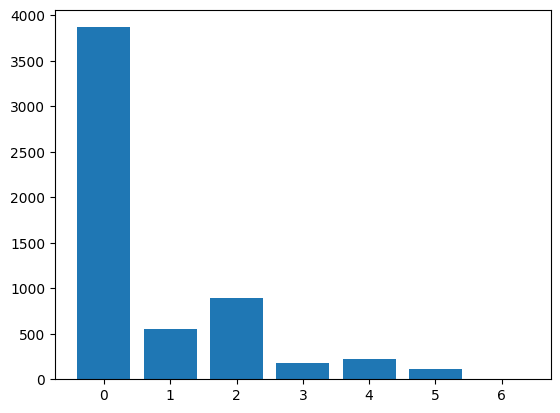

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

y_labels = df.label.unique()
df.label = pd.factorize(df.label)[0]

features = []
for feature in df.columns:
    if feature != 'label':
        features.append(feature)
X = df[features]
y = df['label']

y_encoded = LabelEncoder().fit_transform(y)

counter = Counter(y_encoded)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
plt.bar(counter.keys(), counter.values())
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [8]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3065,  443,  740,  143,  173,   98,    5]))

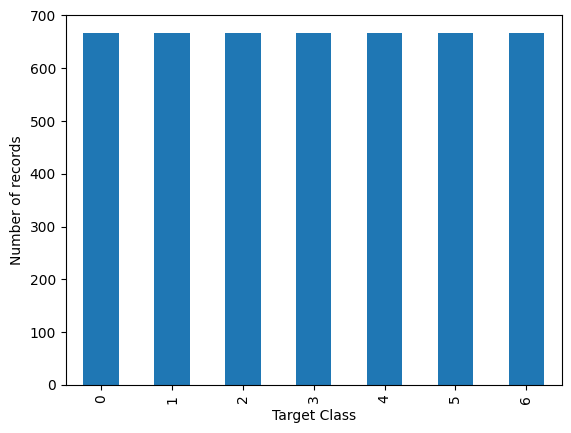

In [9]:
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE

n_samples = int(round(np.unique(y_train, return_counts=True)[1].mean()))

def sampling_strategy(X, y, n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X_train, y_train, n_samples, t='majority'), random_state=1337)
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under, n_samples, t='minority'), k_neighbors=2, random_state=1337)

X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

count = y_bal.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

In [10]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.callbacks import History

2023-01-19 03:02:00.218987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
def evaluat_my_model(model, input_data, output_data):
    
    output_data = output_data.values.reshape(-1,1)
    output_data = tf.keras.utils.to_categorical(output_data, np.unique(output_data).size)
    
    evaluation_results = model.evaluate(input_data, output_data)

    return evaluation_results

In [12]:
models = []

def create_model(input_data, output_data, layers=[], optimizer="adam", endActi="softmax"):
    
    inputNeurons = input_data.shape[1]
    outputNeurons = np.unique(output_data).size
    
    model = Sequential()
    
    firstLayer = True
    
    for layer in layers:
        if(firstLayer):
            model.add(Dense(layer[0], input_shape=(inputNeurons,), activation=layer[1]))
            firstLayer = False
        else:
            model.add(Dense(layer[0], activation=layer[1]))
            
        model.add(BatchNormalization())
        
        if(2 < len(layer)):
            model.add(Dropout(layer[2]))
    
    model.add(Dense(outputNeurons, activation=endActi))
    
    if optimizer == "adam":
        opti = Adam(learning_rate = 0.01)
    elif optimizer == "sgd":
        opti = SGD(learning_rate=0.01)
    
    model.compile(loss="categorical_crossentropy", optimizer=opti, metrics=["accuracy"])
    
    return model

def create_fit_model(input_data, output_data, layers=[], optimizer="adam", endActi="softmax", batchSize=50, epochs=100, verbose=0, withHistory=0):
        
        model = create_model(input_data, output_data, layers, optimizer=optimizer, endActi=endActi)
    
        inputNeurons = input_data.shape[1]
        outputNeurons = np.unique(output_data).size

        output_data = output_data.values.reshape(-1,1)
        output_data = tf.keras.utils.to_categorical(output_data, outputNeurons)
        y_test_cat = tf.keras.utils.to_categorical(y_test, outputNeurons)
        
        history = History()
        history = model.fit(x=input_data, y=output_data, batch_size=batchSize, epochs=epochs, verbose=verbose, shuffle=True, validation_data=(X_test, y_test_cat), callbacks=[history])
        evaluate = evaluat_my_model(model=model, input_data=X_test, output_data=y_test)
        models.append({
            'layers':layers,
            'optimizer':optimizer,
            'batchSize':batchSize,
            'epochs':epochs,
            'endActi':endActi,
            'loss':evaluate[0],
            'accuracy':evaluate[1]
            })
        
        if withHistory == 1:
            return model, history
        return model

def plot_acc_loss(history):
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

2023-01-19 03:02:02.303879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


37/37 [==============================] - 0s 564us/step - loss: 0.8826 - accuracy: 0.6144


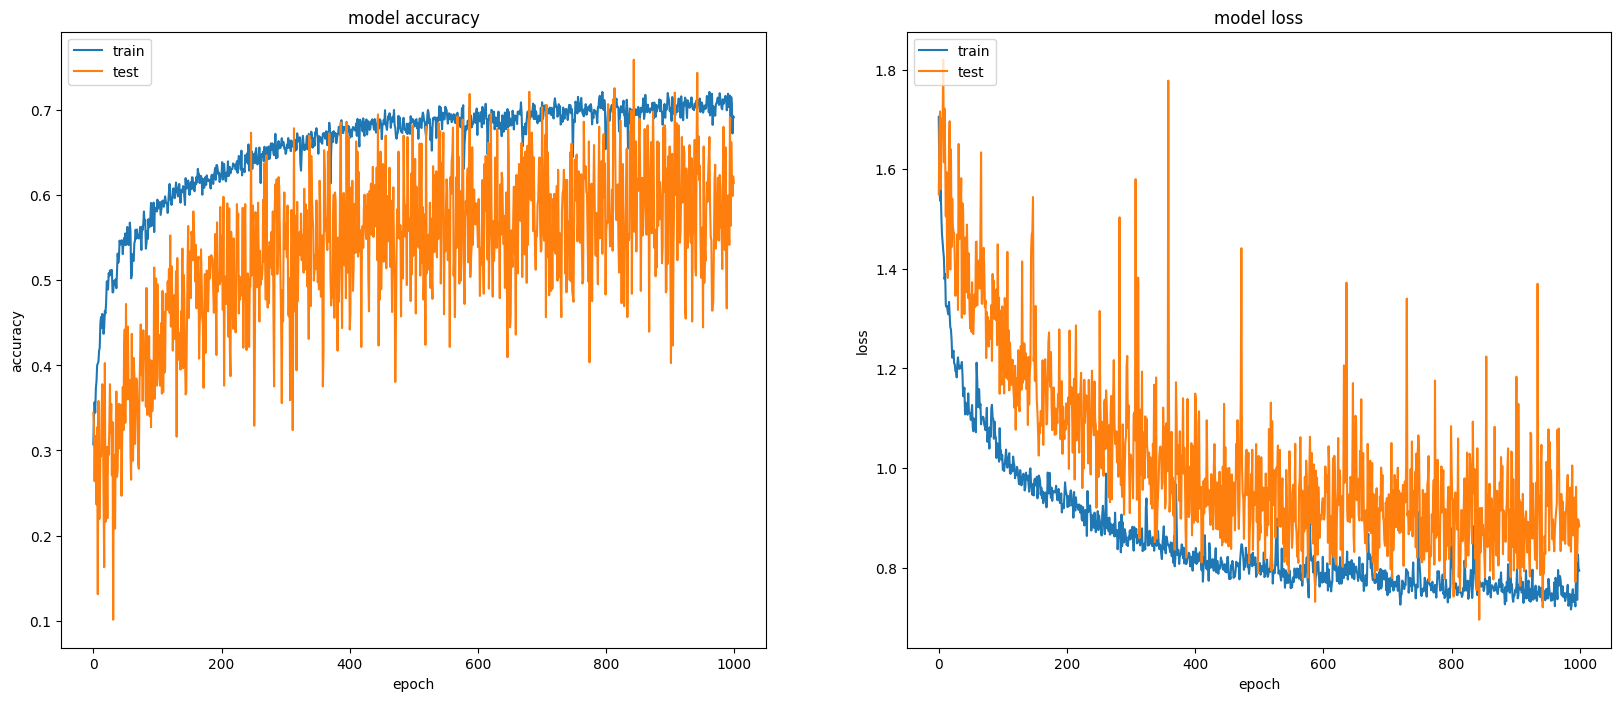

In [13]:
layers = [(150,"relu"),
            (25,"relu",0.2)]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer="adam", endActi="softmax", batchSize=25, epochs=1000, verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 616us/step - loss: 0.7464 - accuracy: 0.7189


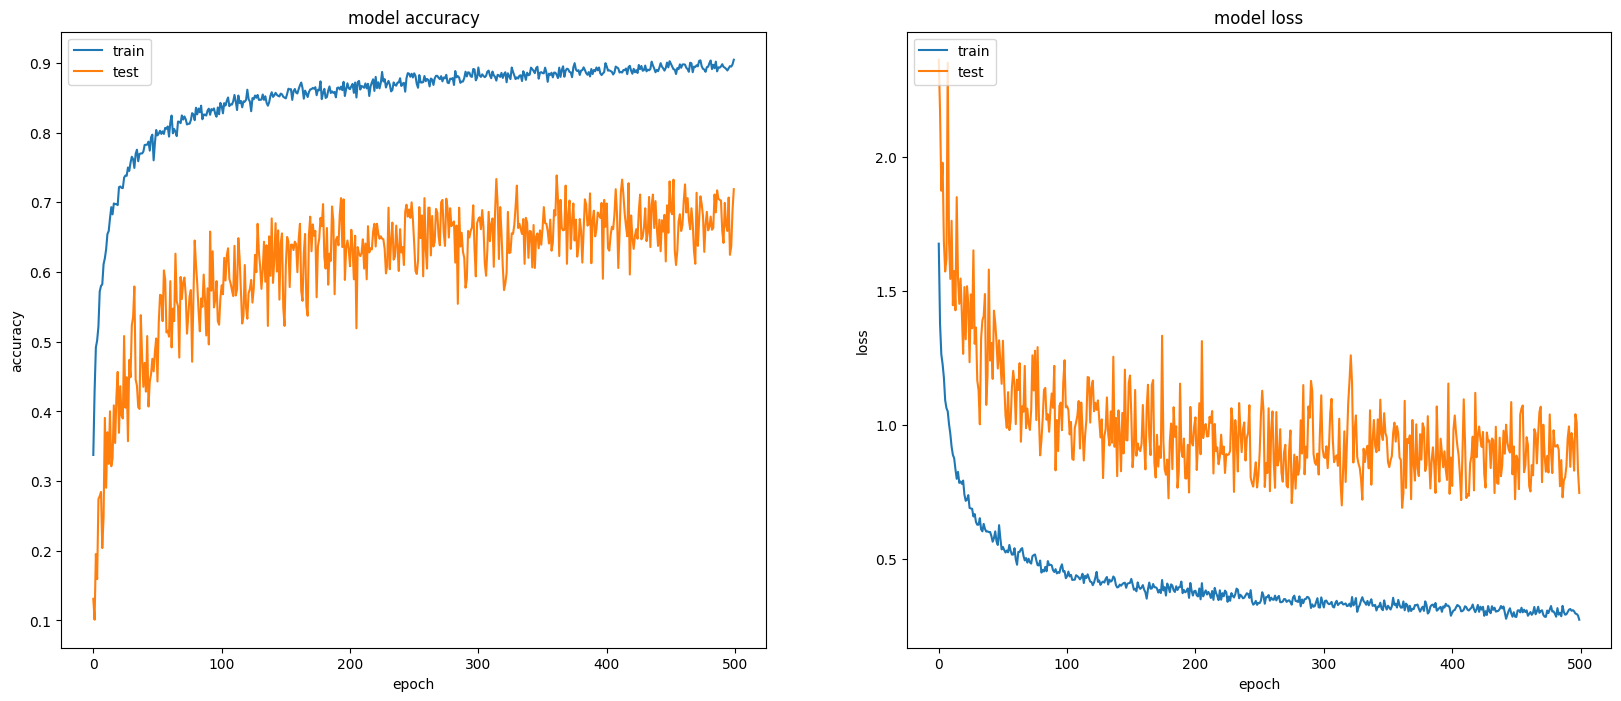

In [14]:
layers = [(100,"relu"),
            (55,"relu")]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer="adam", endActi="softmax", batchSize=100, epochs=500, verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 550us/step - loss: 1.1421 - accuracy: 0.4670


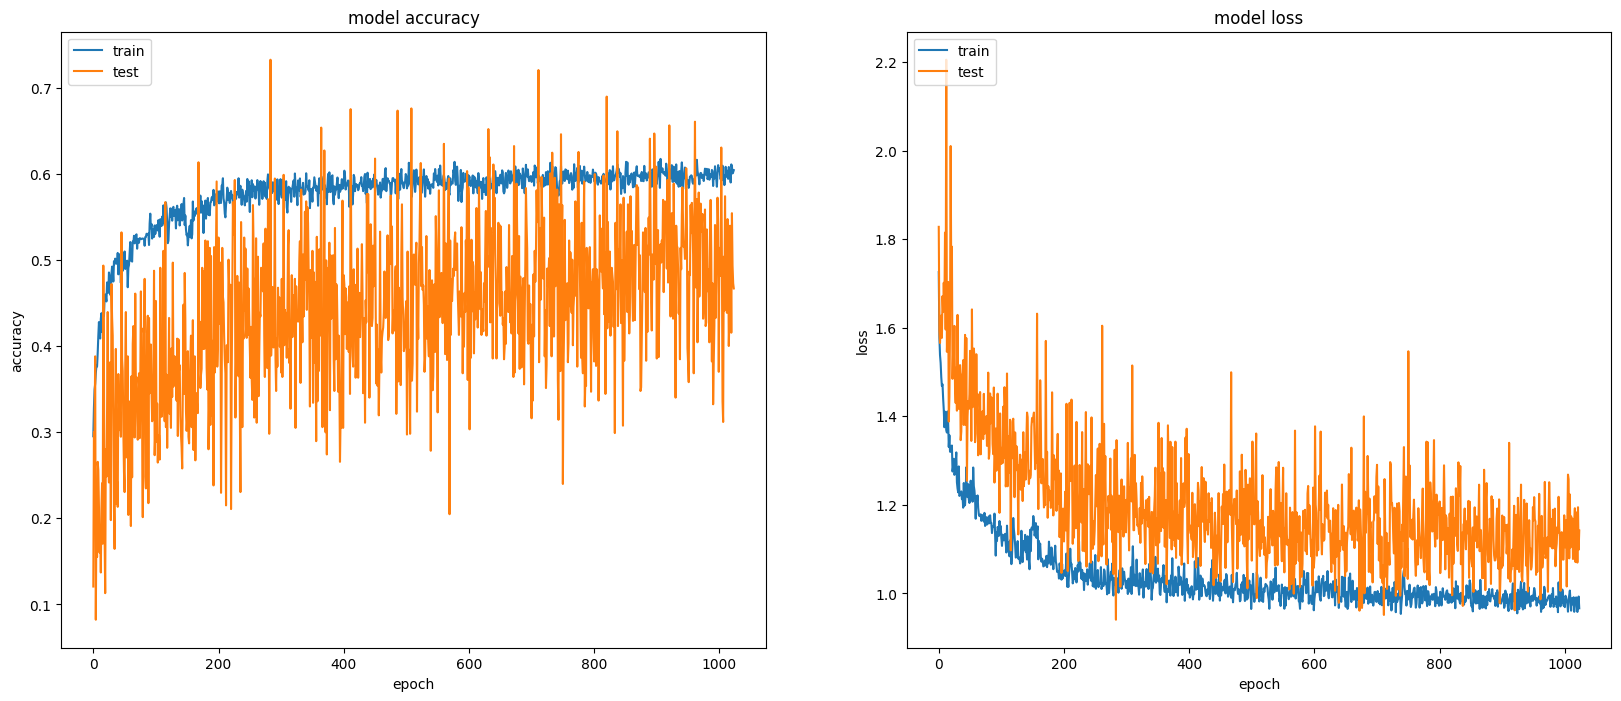

In [15]:
layers = [(100,"relu"),
            (25,"sigmoid",0.2)]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer="adam", endActi="softmax", batchSize=16, epochs=1024, verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 572us/step - loss: 1.8010 - accuracy: 0.2005


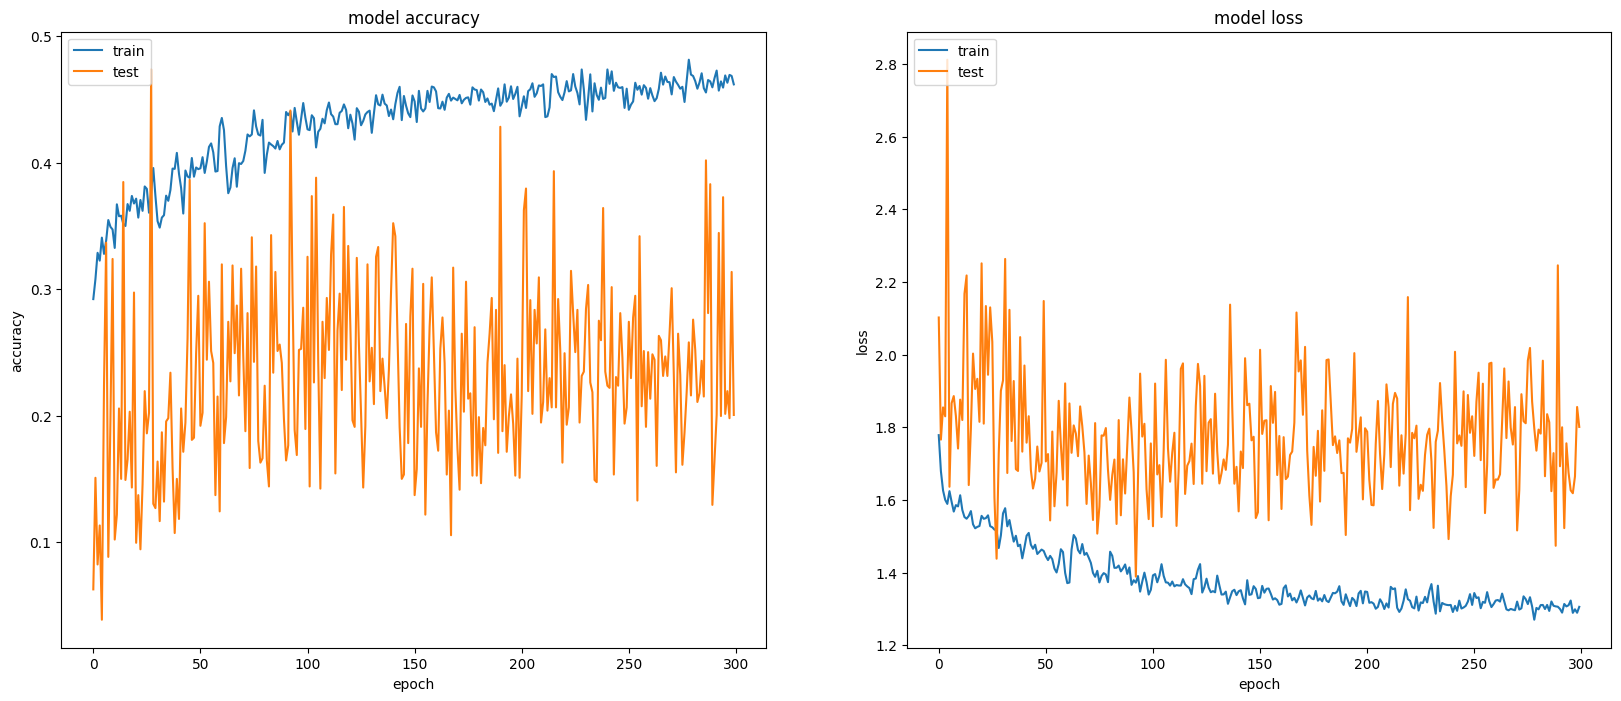

In [16]:
layers = [(20,"relu"),
            (80,"sigmoid")]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer="adam", endActi="softmax", batchSize=10, epochs=300, verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 612us/step - loss: 1.5693 - accuracy: 0.4130


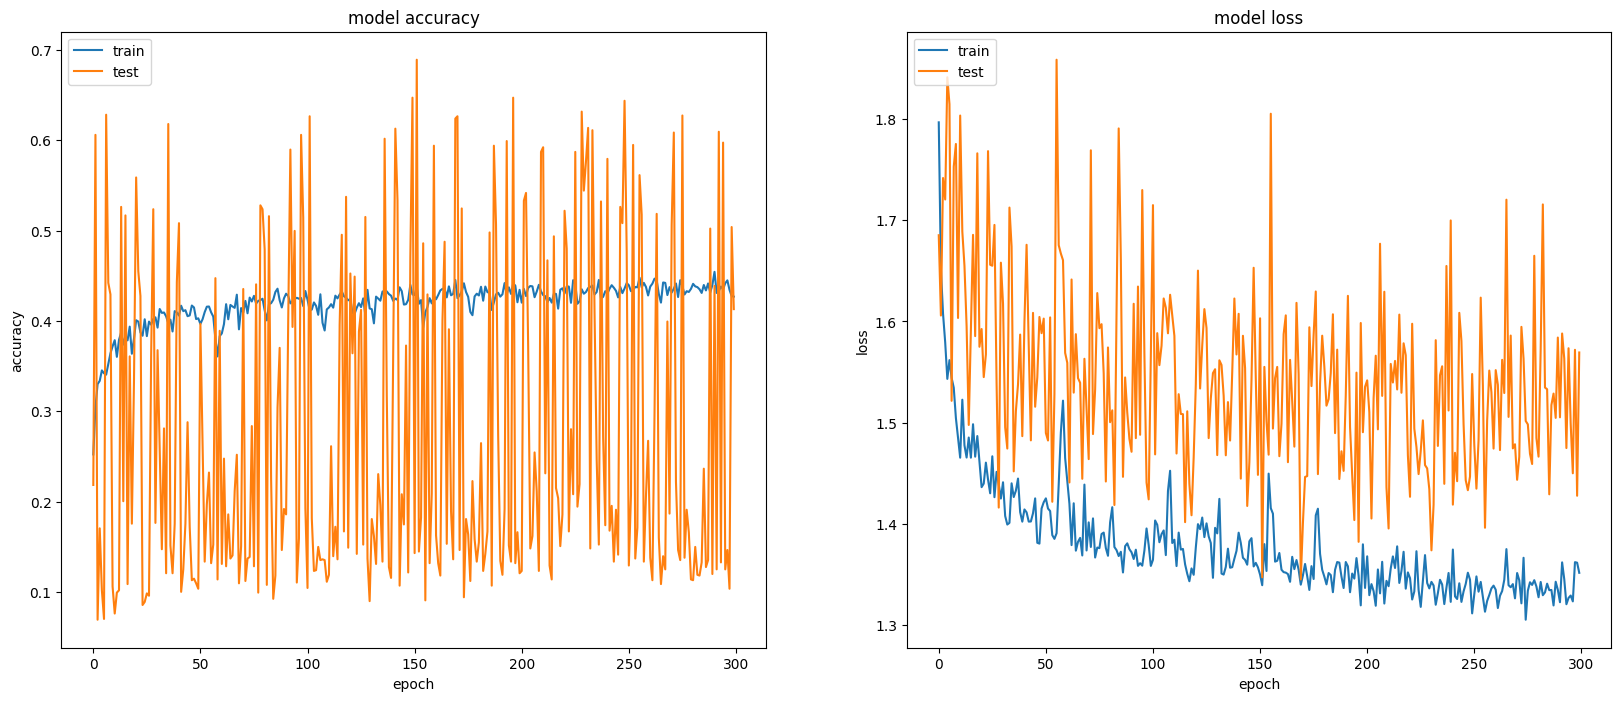

In [17]:
layers = [(20,"relu"),
            (10,"tanh",0.2)]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer="adam", endActi="softmax", batchSize=15, epochs=300, verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 573us/step - loss: 1.9664 - accuracy: 0.1859


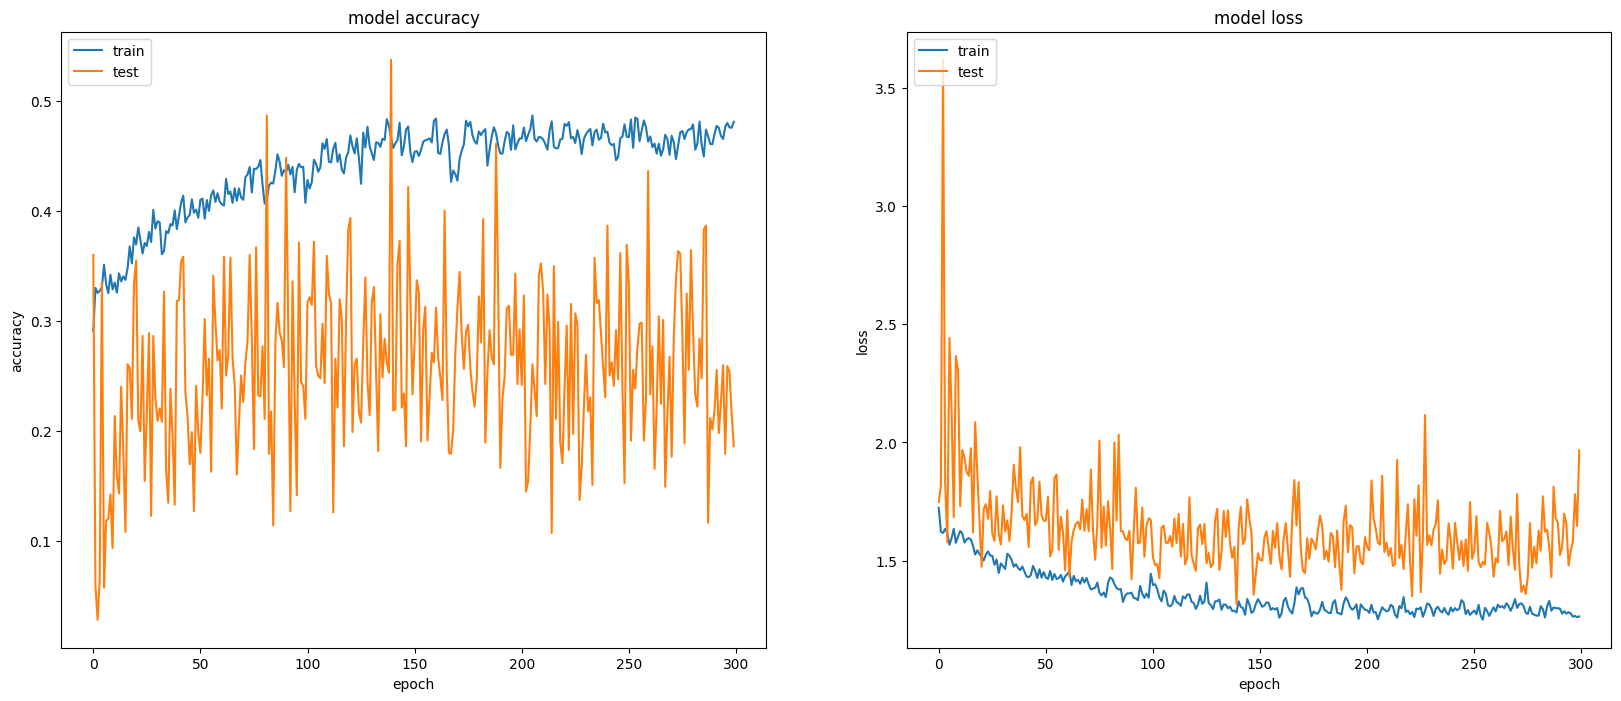

In [18]:
layers = [(50,"relu"),
            (25,"tanh")]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer="adam", endActi="softmax", batchSize=10, epochs=300, verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 559us/step - loss: 1.9095 - accuracy: 0.1714


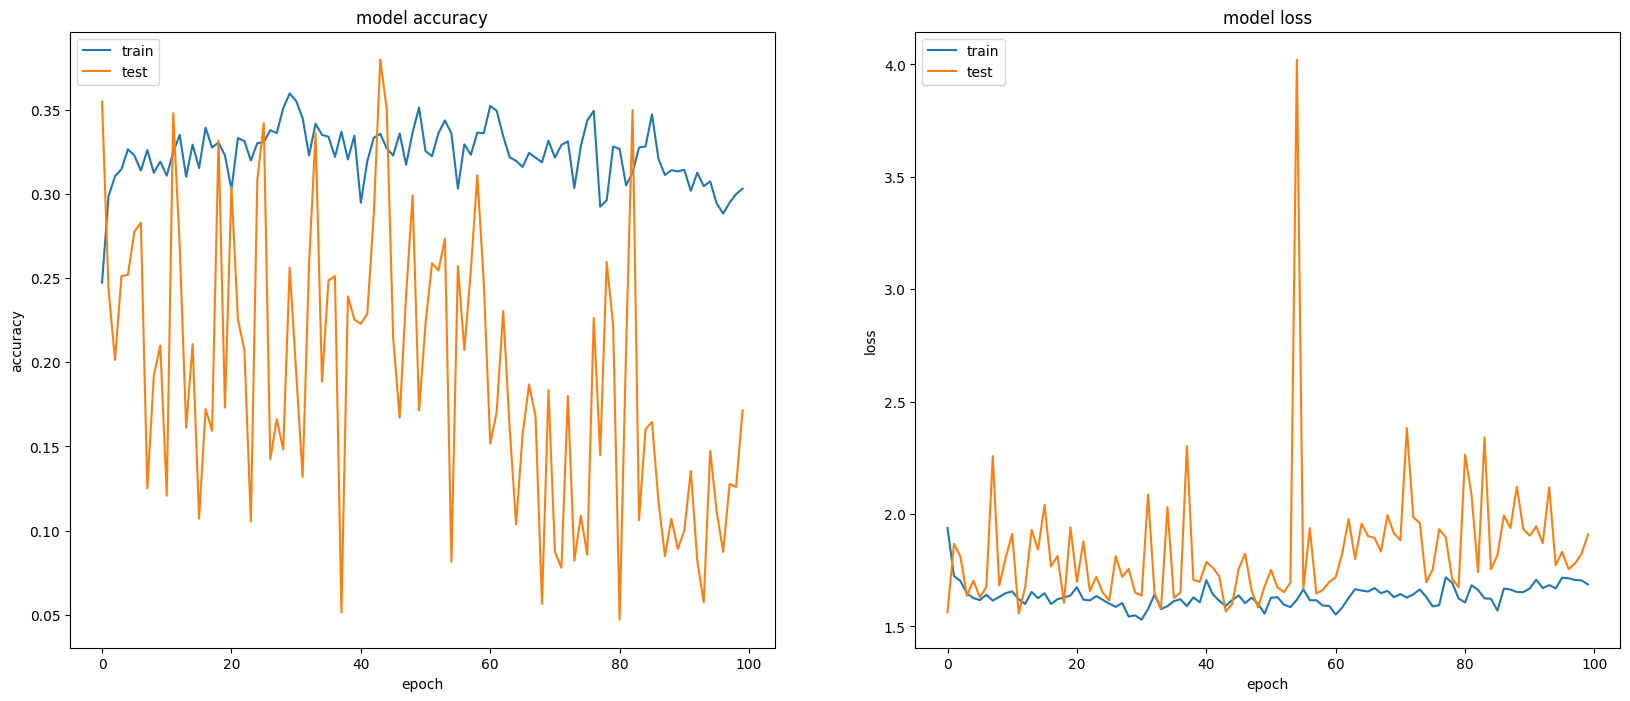

In [19]:
layers = [(50,"relu"),
            (25,"relu",0.2)]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer="sgd", endActi="softmax", batchSize=10, epochs=100, verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 614us/step - loss: 1.6596 - accuracy: 0.1611


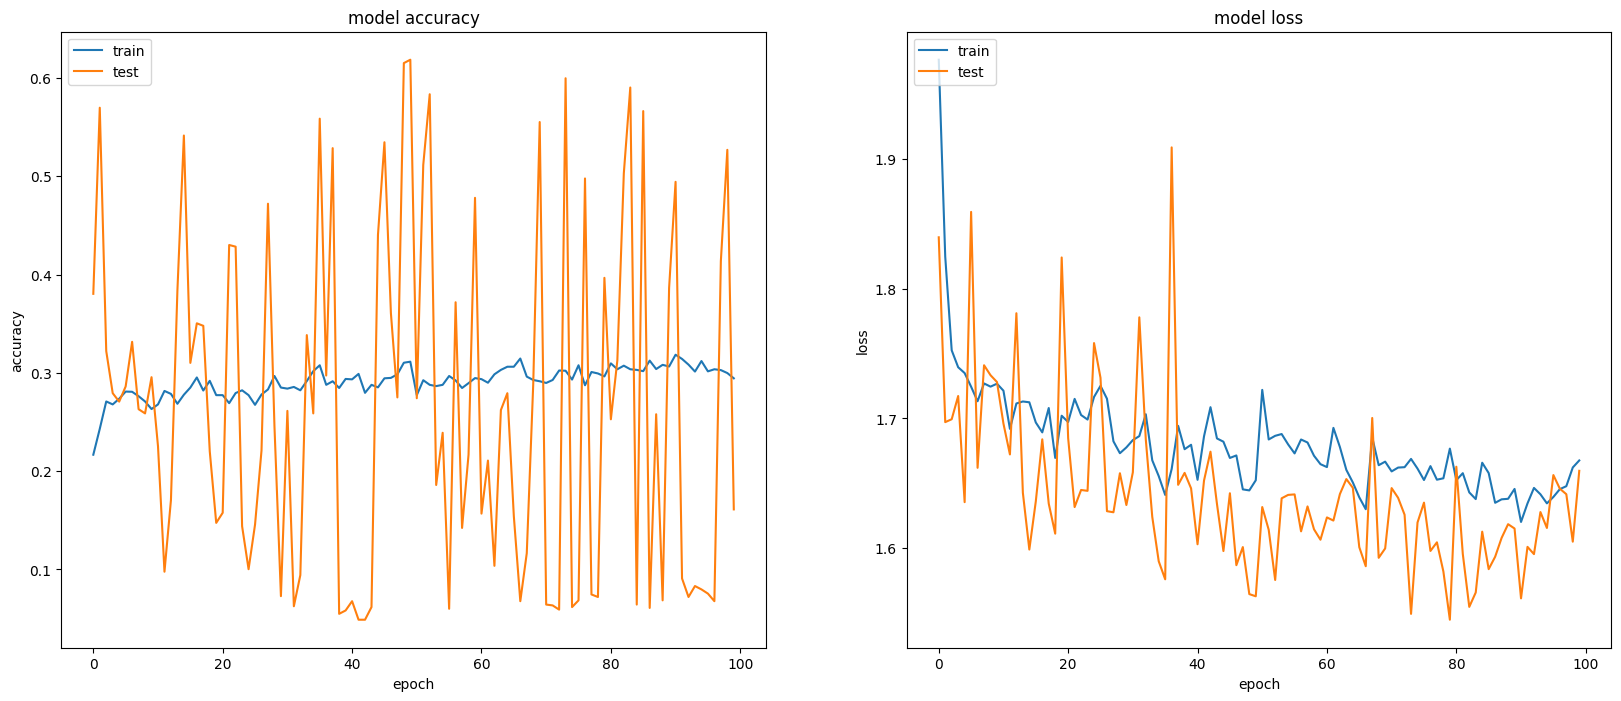

In [20]:
layers = [(50,"relu"),
            (25,"relu",0.2),
         (10,"sigmoid",0.3),
         (5,"relu",0.2)]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer="sgd", endActi="softmax", batchSize=10, epochs=100, verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 597us/step - loss: 1.7813 - accuracy: 0.0480


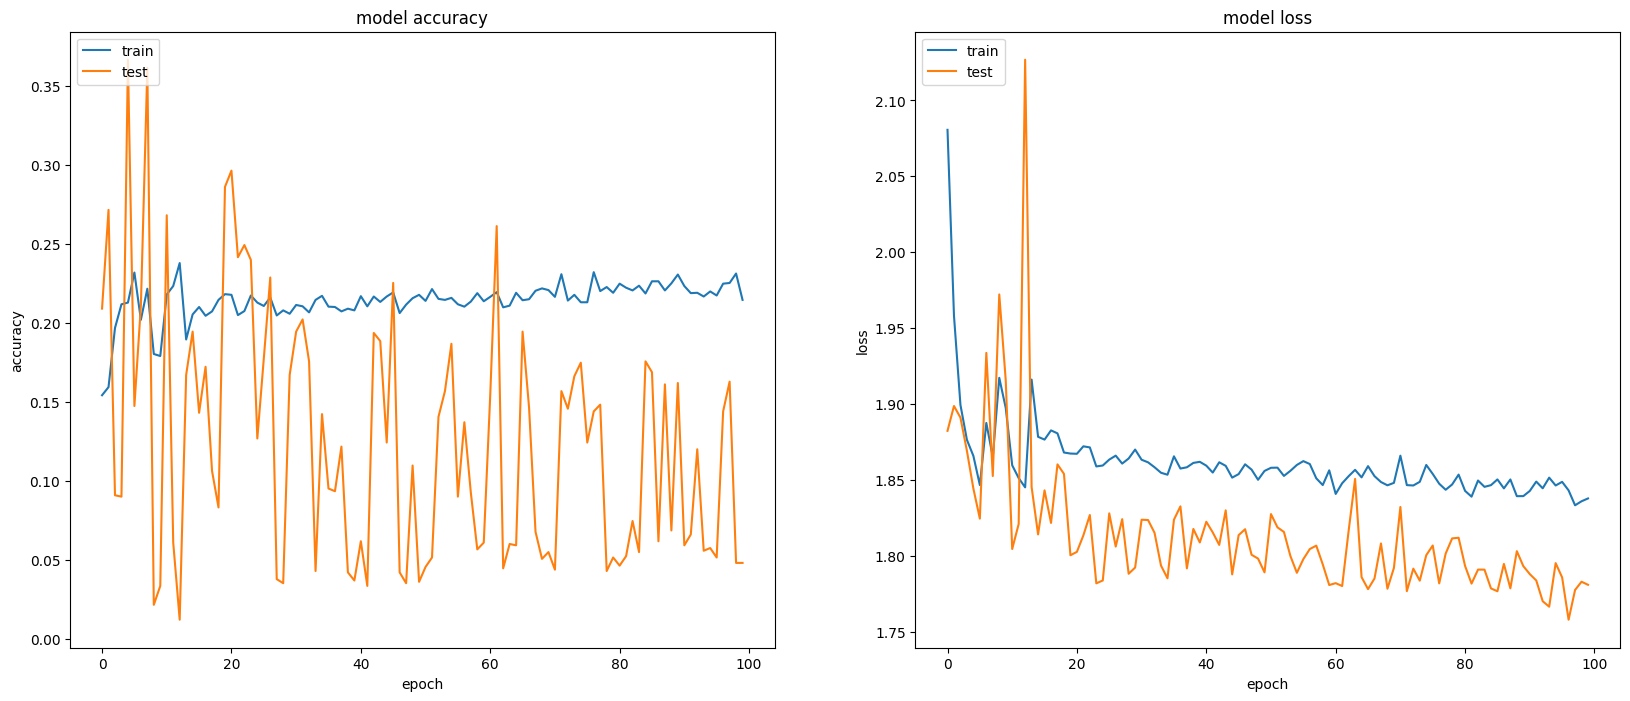

In [21]:
layers = [(10,"relu"),
            (5,"relu",0.2),
         (10,"tanh",0.3),
         (5,"relu",0.2)]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer="sgd", endActi="softmax", batchSize=10, epochs=100, verbose=0, withHistory=1)
plot_acc_loss(history)

In [22]:
models

[{'layers': [(150, 'relu'), (25, 'relu', 0.2)],
  'optimizer': 'adam',
  'batchSize': 25,
  'epochs': 1000,
  'endActi': 'softmax',
  'loss': 0.8826299905776978,
  'accuracy': 0.6143959164619446},
 {'layers': [(100, 'relu'), (55, 'relu')],
  'optimizer': 'adam',
  'batchSize': 100,
  'epochs': 500,
  'endActi': 'softmax',
  'loss': 0.746422290802002,
  'accuracy': 0.7189374566078186},
 {'layers': [(100, 'relu'), (25, 'sigmoid', 0.2)],
  'optimizer': 'adam',
  'batchSize': 16,
  'epochs': 1024,
  'endActi': 'softmax',
  'loss': 1.1420986652374268,
  'accuracy': 0.46700942516326904},
 {'layers': [(20, 'relu'), (80, 'sigmoid')],
  'optimizer': 'adam',
  'batchSize': 10,
  'epochs': 300,
  'endActi': 'softmax',
  'loss': 1.8010109663009644,
  'accuracy': 0.20051413774490356},
 {'layers': [(20, 'relu'), (10, 'tanh', 0.2)],
  'optimizer': 'adam',
  'batchSize': 15,
  'epochs': 300,
  'endActi': 'softmax',
  'loss': 1.5693166255950928,
  'accuracy': 0.4130248427391052},
 {'layers': [(50, 'rel

In [23]:
def get_best_acc_model():
    bestItem = max(models, key=lambda x:x['accuracy'])
    return bestItem
def get_best_loss_model():
    bestItem = min(models, key=lambda x:x['loss'])
    return bestItem

In [24]:
best_model = get_best_acc_model()
best_model

{'layers': [(100, 'relu'), (55, 'relu')],
 'optimizer': 'adam',
 'batchSize': 100,
 'epochs': 500,
 'endActi': 'softmax',
 'loss': 0.746422290802002,
 'accuracy': 0.7189374566078186}

In [25]:
layers = best_model['layers']
model,history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)

37/37 [==============================] - 0s 573us/step - loss: 0.8936 - accuracy: 0.6418


In [26]:
model.save('best_model')
model = 0

INFO:tensorflow:Assets written to: best_model/assets


In [27]:
model = keras.models.load_model('best_model')

In [28]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def analyse_my_mode(model, history):
    model.summary()
    print("\n")
    predictions = model.predict(X_test, verbose=0)
    y_pred = (predictions > 0.5)
    y_test_=y_test.astype(int).tolist()
    print(confusion_matrix(y_test_, y_pred.argmax(axis=1)))
    print("\n")
    print(classification_report(y_true=y_test_,y_pred=y_pred.argmax(axis=1), target_names=y_labels,zero_division=0))
    print("\n")
    
    plot_acc_loss(history);

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 100)               600       
                                                                 
 batch_normalization_22 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 55)                5555      
                                                                 
 batch_normalization_23 (Bat  (None, 55)               220       
 chNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 7)                 392       
                                                                 
Total params: 7,167
Trainable params: 6,857
Non-traina

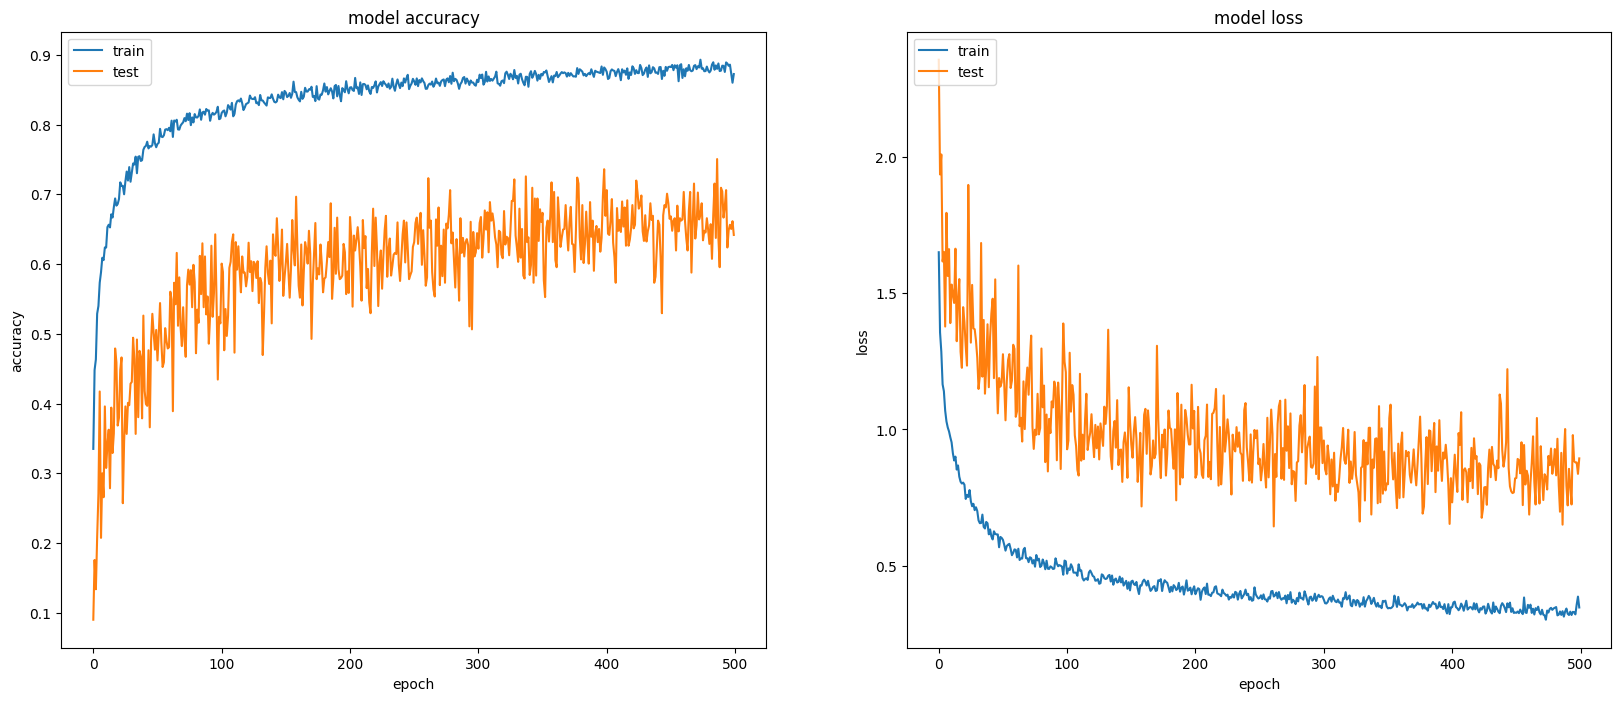

In [29]:
analyse_my_mode(model, history)

In [30]:
def predict_result(diceOne, diceTwo, diceThree, diceFour, diceFive, printResult=False):
    _ = model.predict([[diceOne, diceTwo, diceThree, diceFour, diceFive]], verbose=0)
    
    if printResult:
        return _
    
    result = y_labels[np.argmax(_, axis=1)[0]]

    print(result)

In [31]:
predict_result(2,2,2,3,3)

full-house


In [32]:
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(7), fontsize=10)
  plt.xticks(rotation=90)
  plt.yticks([])
  thisplot = plt.bar(y_labels, predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

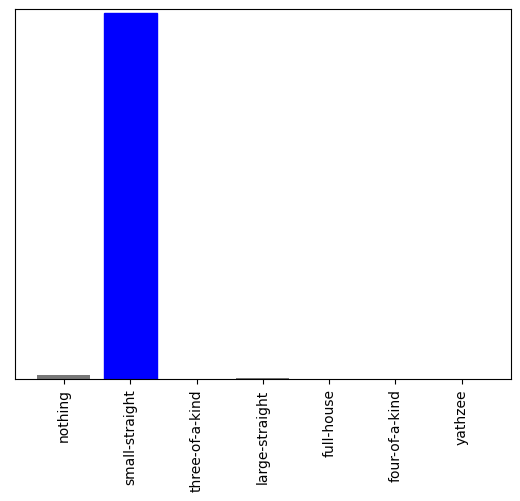

In [33]:
i = 0
prediction = model.predict([[1, 3, 2, 4, 3]], verbose=0)
plot_value_array(i, prediction[i], [1]) #small-straight

In [34]:
#Basic from: https://www.tensorflow.org/tutorials/keras/classification
def plot_bars(num_rows=5, num_cols=3):
    predictions = model.predict(X_test)
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 3*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, num_cols, i+1)
      plot_value_array(i, predictions[i], y_test.reset_index(drop=True))
      dices = np.array(X_test.reset_index(drop=True))[i]
      title = str(dices[0]) + "," + str(dices[1]) + "," + str(dices[2]) + "," + str(dices[3]) + "," + str(dices[4])
      plt.title(title)
      plt.subplots_adjust(hspace=1.2)
    plt.show()

37/37 [==============================] - 0s 556us/step


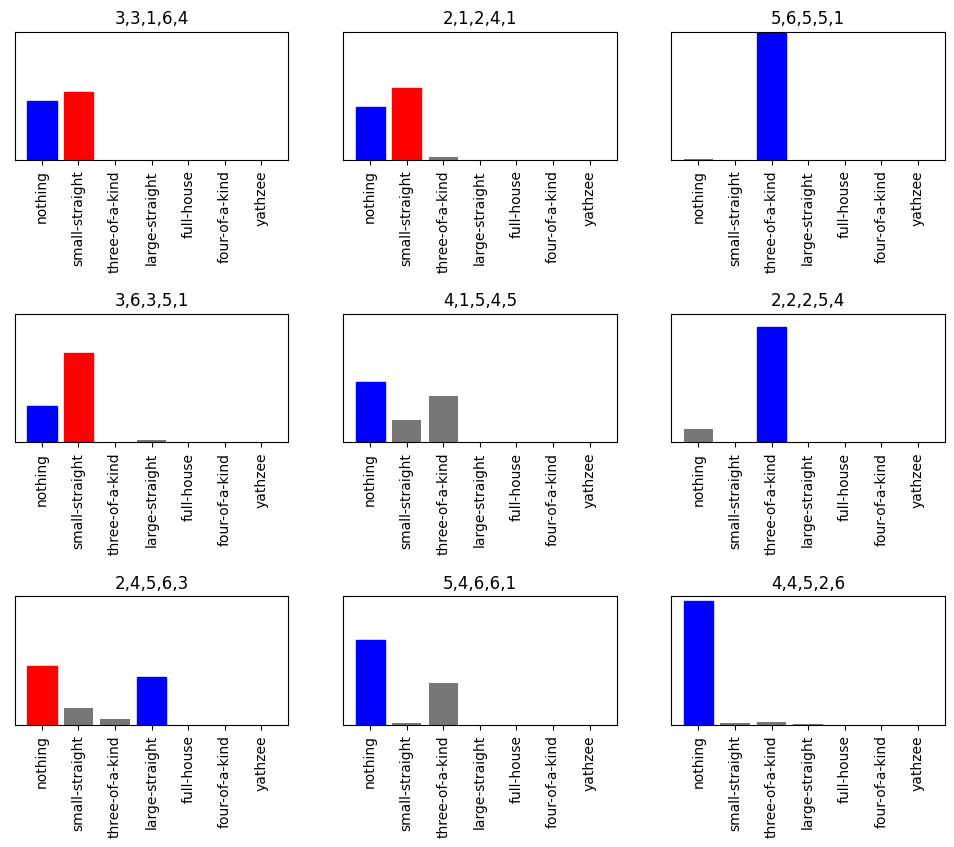

In [35]:
plot_bars(3,3)